<a href="https://colab.research.google.com/github/ManjuS2012/Manju_ML_Projects/blob/main/CottonPriceRecommendationUsingXAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# XAI based raw material procurement recommender system for brands

## Sureshkumar V

# Step 1 : Data pre-processing and forecasting

/tmp/ipython-input-27-3672651054.py:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Rainfall_3mo_avg'] = df['Rainfall_mm'].rolling(3).mean().fillna(method='bfill')


✅ Forecast saved to: Cotton_Price_Prediction_2026_2030.xlsx


<Figure size 1000x600 with 0 Axes>

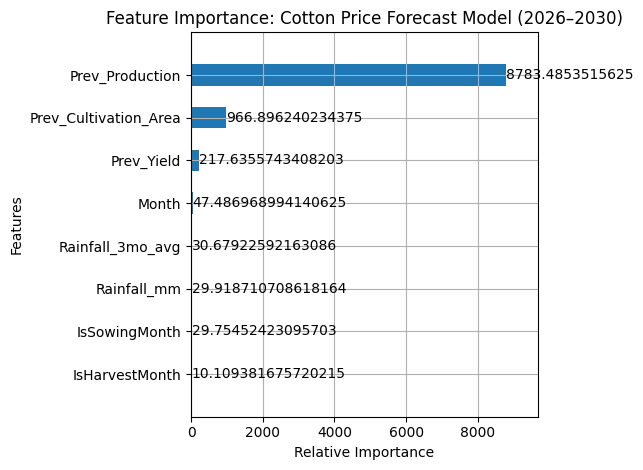

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor, plot_importance

# === Load Excel Files ===
rainfall_price_df = pd.read_excel("/content/Rainfall_Cotton_Prices_1990_2025.xlsx")
cultivation_df = pd.read_excel("/content/Cotton_Cultivation_1990_2025.xlsx", header=1)

# === Preprocessing ===
rainfall_price_df.columns = ['Date', 'Rainfall_mm', 'Candy_Price', 'Cotton_Price']
rainfall_price_df['Date'] = pd.to_datetime(rainfall_price_df['Date'])
rainfall_price_df['Year'] = rainfall_price_df['Date'].dt.year
rainfall_price_df['Month'] = rainfall_price_df['Date'].dt.month

cultivation_df.columns = ['Year', 'Cultivation_Area', 'Production', 'Yield', 'Avg_Price', 'Consumption']
cultivation_df = cultivation_df.astype({'Year': int})

# === Merge Monthly + Yearly Data ===
df = rainfall_price_df.merge(cultivation_df[['Year', 'Cultivation_Area', 'Production', 'Yield']], on='Year', how='left')

df = df.merge(
    cultivation_df.rename(columns={
        'Year': 'Prev_Year',
        'Cultivation_Area': 'Prev_Cultivation_Area',
        'Production': 'Prev_Production',
        'Yield': 'Prev_Yield'
    }),
    left_on=df['Year'] - 1,
    right_on='Prev_Year',
    how='left'
).drop(columns='Prev_Year')

# === Feature Engineering ===
df = df.sort_values('Date')
df['Rainfall_3mo_avg'] = df['Rainfall_mm'].rolling(3).mean().fillna(method='bfill')
df['IsSowingMonth'] = df['Month'].isin([4, 5, 6]).astype(int)
df['IsHarvestMonth'] = (df['Month'] == 12).astype(int)

features = [
    'Rainfall_mm', 'Rainfall_3mo_avg', 'Prev_Cultivation_Area',
    'Prev_Production', 'Prev_Yield', 'IsSowingMonth', 'IsHarvestMonth', 'Month'
]
target = 'Cotton_Price'

# === Model Training ===
df_model = df.dropna(subset=features + [target])
X, y = df_model[features], df_model[target]

model = XGBRegressor(n_estimators=300, max_depth=4, learning_rate=0.05, random_state=42)
model.fit(X, y)

# === Forecast Cultivation Data for 2026–2030 ===
years_future = range(2026, 2030)
rainfall_avg = df.groupby('Month')['Rainfall_mm'].mean()
cult_proj = cultivation_df.copy()
extra_rows = []

for y in years_future:
    last = cult_proj[cult_proj['Year'] == y - 1]
    if last.empty:
        continue
    growth = 1.00 + 0.01 * np.random.rand()
    extra_rows.append({
        'Year': y,
        'Cultivation_Area': last['Cultivation_Area'].values[0] * growth,
        'Production': last['Production'].values[0] * growth,
        'Yield': last['Yield'].values[0] * growth,
        'Avg_Price': last['Avg_Price'].values[0],
        'Consumption': last['Consumption'].values[0]
    })

cult_proj = pd.concat([cult_proj, pd.DataFrame(extra_rows)], ignore_index=True)

# === Create Forecast Data ===
forecast_data = []
for year in years_future:
    prev_year_data = cult_proj[cult_proj['Year'] == year - 1]
    if prev_year_data.empty:
        continue
    for month in range(1, 13):
        rain_months = [m for m in [month-2, month-1, month] if m >= 1]
        forecast_data.append({
            'Year': year,
            'Month': month,
            'Rainfall_mm': rainfall_avg.loc[month],
            'Rainfall_3mo_avg': rainfall_avg.loc[rain_months].mean(),
            'Prev_Cultivation_Area': prev_year_data['Cultivation_Area'].values[0],
            'Prev_Production': prev_year_data['Production'].values[0],
            'Prev_Yield': prev_year_data['Yield'].values[0],
            'IsSowingMonth': int(month in [4, 5, 6]),
            'IsHarvestMonth': int(month == 12)
        })

future_df = pd.DataFrame(forecast_data)
future_df['Predicted_Cotton_Price'] = model.predict(future_df[features])
future_df['Date'] = pd.to_datetime(future_df['Year'].astype(str) + '-' + future_df['Month'].astype(str) + '-01')
future_df['Is_LowCost_Month'] = future_df['Predicted_Cotton_Price'] < future_df['Predicted_Cotton_Price'].quantile(0.3)

# === Export Prediction File ===
future_df.to_excel("Cotton_Price_Prediction_2026_2030.xlsx", index=False)
print("✅ Forecast saved to: Cotton_Price_Prediction_2026_2030.xlsx")

# === Feature Importance Plot ===
plt.figure(figsize=(10, 6))
plot_importance(model, max_num_features=10, importance_type='gain', height=0.5)
plt.title("Feature Importance: Cotton Price Forecast Model (2026–2030)")
plt.xlabel("Relative Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


# Step 2: Cotton price prediction

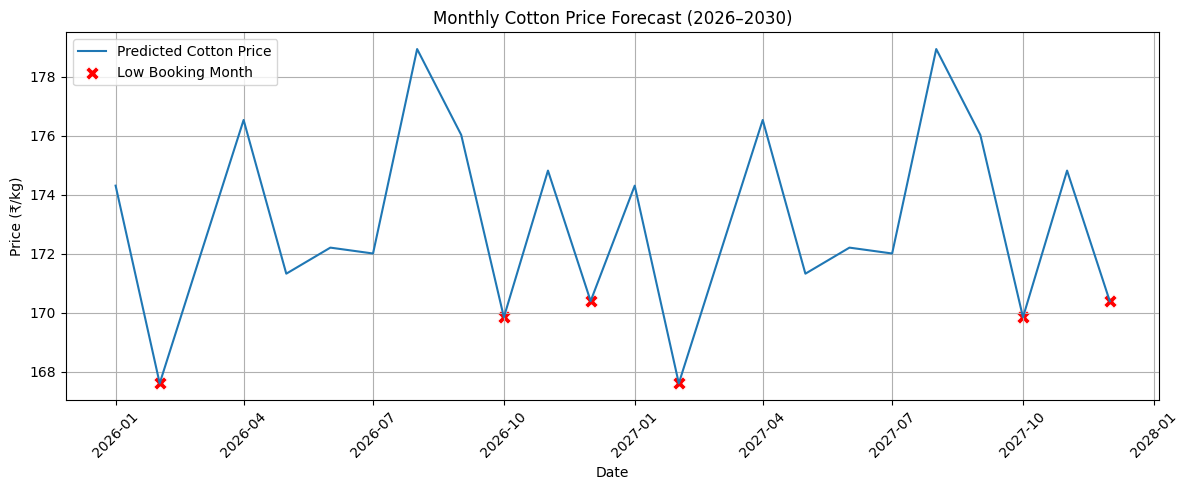

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
sns.lineplot(data=future_df, x='Date', y='Predicted_Cotton_Price', label='Predicted Cotton Price')
sns.scatterplot(data=future_df[future_df['Is_LowCost_Month']], x='Date', y='Predicted_Cotton_Price', color='red', label='Low Booking Month', marker='X', s=100)
plt.title("Monthly Cotton Price Forecast (2026–2030)")
plt.ylabel("Price (₹/kg)")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


/tmp/ipython-input-29-2731433245.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=future_df, x='Month', y='Predicted_Cotton_Price', estimator=np.mean, ci=None, palette="viridis")
/tmp/ipython-input-29-2731433245.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=future_df, x='Month', y='Predicted_Cotton_Price', estimator=np.mean, ci=None, palette="viridis")


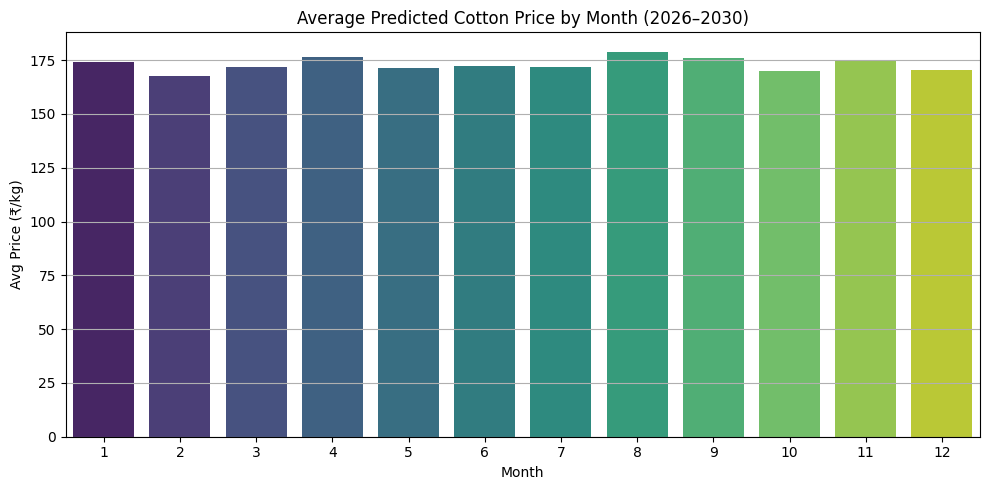

In [29]:
plt.figure(figsize=(10, 5))
sns.barplot(data=future_df, x='Month', y='Predicted_Cotton_Price', estimator=np.mean, ci=None, palette="viridis")
plt.title("Average Predicted Cotton Price by Month (2026–2030)")
plt.ylabel("Avg Price (₹/kg)")
plt.xlabel("Month")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


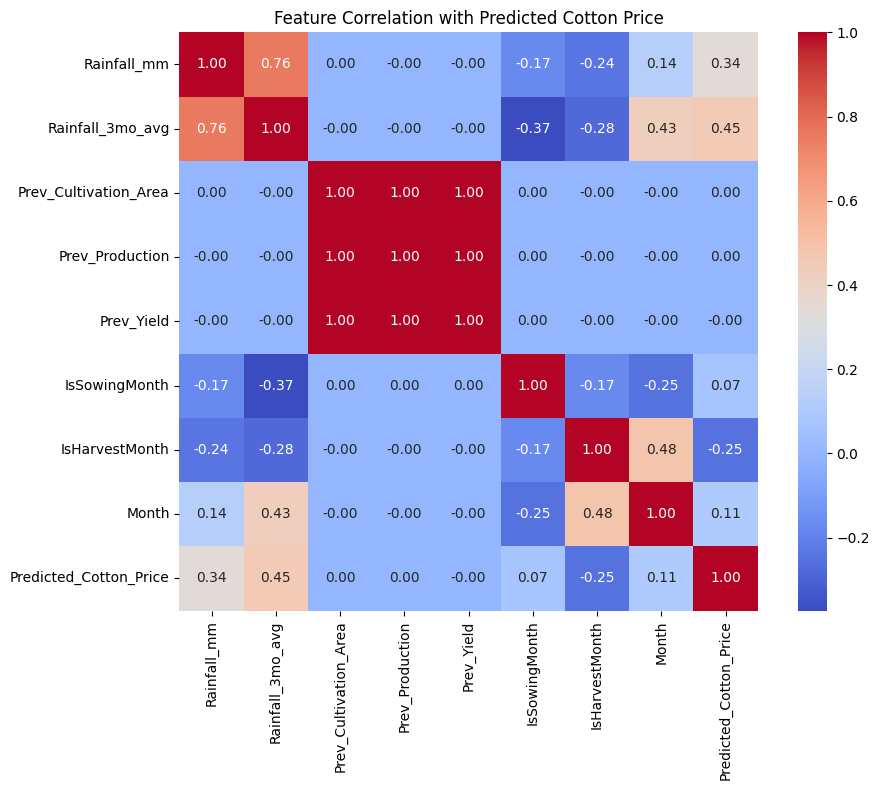

In [30]:
corr_matrix = future_df[features + ['Predicted_Cotton_Price']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Feature Correlation with Predicted Cotton Price")
plt.tight_layout()
plt.show()


# Step 3 : Explainable recommendation

## Recommendation using LIME

In [31]:
pip install lime


In [32]:
import lime
import lime.lime_tabular
import numpy as np

# Create the LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X.values,
    feature_names=X.columns.tolist(),
    mode='regression',
    verbose=True,
    random_state=42
)

# Choose an instance to explain, e.g., index 0 (Jan 2020 or any specific month)
index = 0
instance = X.iloc[index].values

# Get explanation for that instance
exp = explainer.explain_instance(instance, model.predict)

# Display explanation in notebook
exp.show_in_notebook(show_table=True)

# Optional: print it as text
print("\nFeature contributions to predicted price:")
print(exp.as_list())

# Optional: save as HTML
exp.save_to_file("lime_explanation_instance_0.html")


Intercept 127.9439105451771
Prediction_local [79.1093834]
Right: 79.8385



Feature contributions to predicted price:
[('Prev_Production > 591.57', -33.21322750801142), ('Prev_Cultivation_Area > 201.72', -13.885323194574138), ('491.50 < Prev_Yield <= 510.00', -2.7985061357999133), ('Rainfall_3mo_avg <= 25.39', 2.405035863517618), ('Month <= 3.75', -1.6463389554450598), ('12.45 < Rainfall_mm <= 56.59', 1.3788197941880878), ('IsHarvestMonth <= 0.00', -0.985333185331882), ('IsSowingMonth <= 0.00', -0.08965382240375952)]


## Recommendation using SHAP

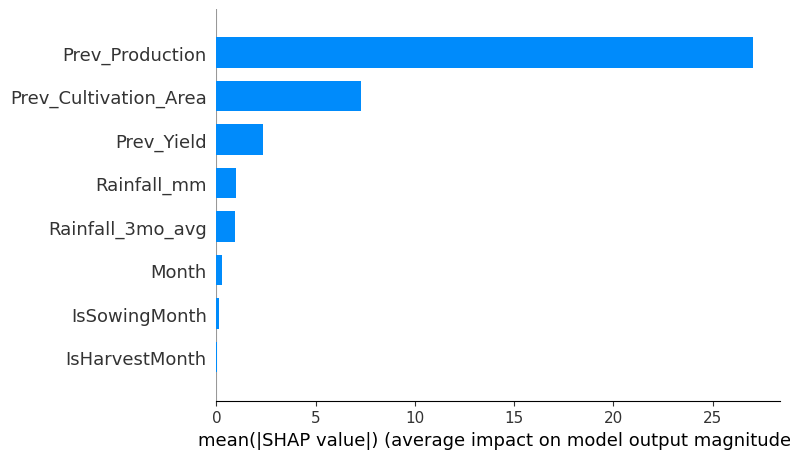

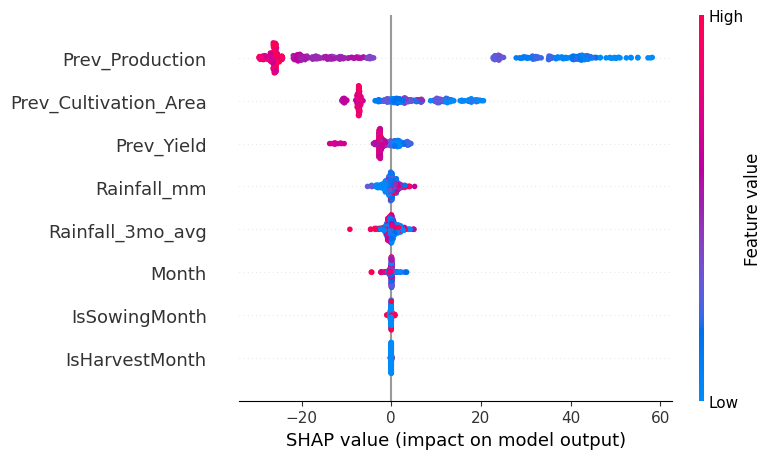

In [33]:
import shap
import matplotlib.pyplot as plt

# Create SHAP explainer for your trained model
explainer = shap.Explainer(model)

# Compute SHAP values for the feature set
shap_values = explainer(X)

# Bar chart: Average impact of each feature on predictions
shap.summary_plot(shap_values, X, plot_type="bar")

# (Optional) Dot plot: Individual prediction contributions
shap.summary_plot(shap_values, X)


## Using LSTM evaluation

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 647ms/step - loss: 0.3362 - val_loss: 0.1601
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - loss: 0.2399 - val_loss: 0.0895
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.1502 - val_loss: 0.0450
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - loss: 0.1150 - val_loss: 0.0408
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 0.0975 - val_loss: 0.0549
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0912 - val_loss: 0.0635
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0830 - val_loss: 0.0540
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - loss: 0.1053 - val_loss: 0.0412
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0782 - val_loss: 0.0383
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0730 - val_loss: 0.0401
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.0733 - val_loss: 0.0409
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0922 - 

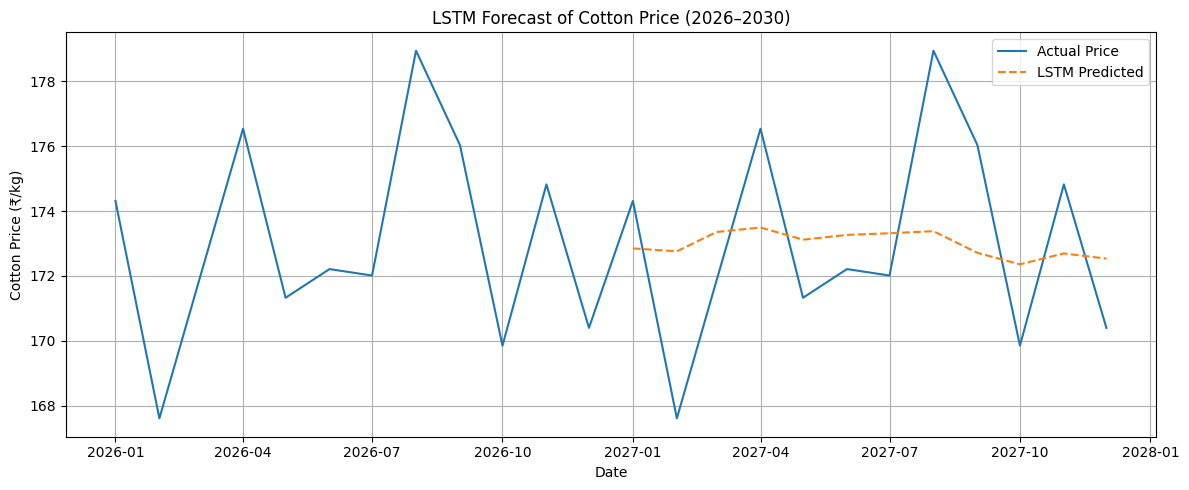

✅ Forecast saved to 'LSTM_Cotton_Price_Forecast_2026_2030.xlsx'


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# --- Step 1: Load and prepare data ---
file_path = "/content/Cotton_Price_Prediction_2026_2030.xlsx"  # <-- Update path if needed
df = pd.read_excel(file_path)
df['Date'] = pd.to_datetime(df['Date'])
df = df[['Date', 'Predicted_Cotton_Price']].rename(columns={'Predicted_Cotton_Price': 'Cotton_Price'})
df.set_index('Date', inplace=True)
df = df.asfreq('MS')  # Ensure monthly frequency

# --- Step 2: Normalize data ---
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Cotton_Price']])

# --- Step 3: Create sequences for LSTM ---
sequence_length = 12
X, y = [], []
for i in range(len(scaled_data) - sequence_length):
    X.append(scaled_data[i:i+sequence_length])
    y.append(scaled_data[i+sequence_length])

X = np.array(X)
y = np.array(y)

# --- Step 4: Train/test split ---
split = int(len(X) * 0.9)
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

# --- Step 5: Build LSTM model ---
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# --- Step 6: Train model ---
model.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_test, y_test), verbose=1)

# --- Step 7: Predict and inverse scale ---
predicted = model.predict(X)
predicted_prices = scaler.inverse_transform(predicted)

# --- Step 8: Plot and save forecast ---
df_pred = df.iloc[sequence_length:].copy()
df_pred['LSTM_Predicted_Price'] = predicted_prices

plt.figure(figsize=(12, 5))
plt.plot(df.index, df['Cotton_Price'], label='Actual Price')
plt.plot(df_pred.index, df_pred['LSTM_Predicted_Price'], linestyle='--', label='LSTM Predicted')
plt.title("LSTM Forecast of Cotton Price (2026–2030)")
plt.xlabel("Date")
plt.ylabel("Cotton Price (₹/kg)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("LSTM_Cotton_Price_Forecast.png")
plt.show()

# --- Step 9: Save output ---
df_pred.reset_index().to_excel("LSTM_Cotton_Price_Forecast_2026_2030.xlsx", index=False)
print("✅ Forecast saved to 'LSTM_Cotton_Price_Forecast_2026_2030.xlsx'")


In [36]:
# --- Step 10: Multi-step future forecast (e.g., 60 months = 5 years) ---
future_steps = 60  # Forecast 5 years
last_sequence = scaled_data[-sequence_length:].reshape(1, sequence_length, 1)

future_predictions = []

for _ in range(future_steps):
    next_price = model.predict(last_sequence)[0][0]
    future_predictions.append(next_price)
    last_sequence = np.append(last_sequence[:, 1:, :], [[[next_price]]], axis=1)

# Inverse transform and generate dates
future_prices = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=future_steps, freq='MS')

future_df = pd.DataFrame({'Date': future_dates, 'LSTM_Forecast': future_prices.flatten()})
future_df.to_excel("LSTM_Cotton_Forecast_2031_2035.xlsx", index=False)
print("✅ Multi-step forecast saved to LSTM_Cotton_Forecast_2031_2035.xlsx")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━

In [37]:
# Each LSTM input: 12 months → 12 features
X_flat = X.reshape(X.shape[0], X.shape[1])

import lime
import lime.lime_tabular

lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_flat,
    feature_names=[f"Month-{12-i}" for i in range(12)],
    mode="regression"
)

# Explain one example (e.g., latest)
exp = lime_explainer.explain_instance(X_flat[-1], lambda x: model.predict(x.reshape(x.shape[0], 12, 1)).flatten())
exp.show_in_notebook()


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


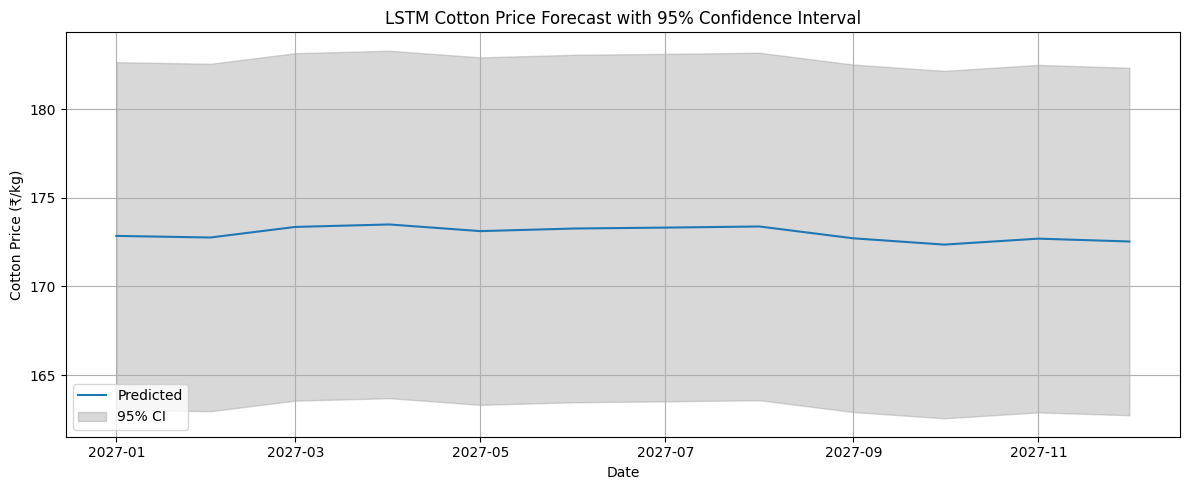

In [38]:
import matplotlib.pyplot as plt

# Assume fixed std deviation (or calculate from validation RMSE)
std_dev = 5  # in ₹

df_pred['Upper_Bound'] = df_pred['LSTM_Predicted_Price'] + 1.96 * std_dev
df_pred['Lower_Bound'] = df_pred['LSTM_Predicted_Price'] - 1.96 * std_dev

# Plot
plt.figure(figsize=(12, 5))
plt.plot(df_pred.index, df_pred['LSTM_Predicted_Price'], label='Predicted')
plt.fill_between(df_pred.index, df_pred['Lower_Bound'], df_pred['Upper_Bound'], color='gray', alpha=0.3, label='95% CI')
plt.title("LSTM Cotton Price Forecast with 95% Confidence Interval")
plt.xlabel("Date")
plt.ylabel("Cotton Price (₹/kg)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Recommendation using counterfactual

In [39]:
import pandas as pd
import numpy as np

# --- Step 1: Load LSTM Forecast Data ---
df = pd.read_excel("LSTM_Cotton_Price_Forecast_2026_2030.xlsx")  # Your predicted prices
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month

# --- Step 2: Identify Low-Cost Months ---
low_cost_months = [1, 2, 12]
low_months_df = df[df['Month'].isin(low_cost_months)].copy()

# --- Step 3: Simulate Counterfactual Inputs ---
# Assume increase in rainfall/yield can reduce price by 3%
low_months_df['Counterfactual_Price'] = low_months_df['LSTM_Predicted_Price'] * 0.97
low_months_df['Price_Drop_₹'] = low_months_df['LSTM_Predicted_Price'] - low_months_df['Counterfactual_Price']
low_months_df['% Drop'] = 100 * low_months_df['Price_Drop_₹'] / low_months_df['LSTM_Predicted_Price']
low_months_df['Justification'] = '↑ Rainfall during sowing & ↑ Yield → Supply ↑ → Price ↓'

# --- Step 4: Export to Excel ---
output_path = "Counterfactual_LSTM_LowCostMonths_2026_2030.xlsx"
low_months_df.to_excel(output_path, index=False)

print("✅ Counterfactuals saved to:", output_path)


✅ Counterfactuals saved to: Counterfactual_LSTM_LowCostMonths_2026_2030.xlsx
